# PyTorch Workflow
1. data (prepare and load)
2. build model
3. training the model
4. making predictions and evaluating the model
5. saving and loading a model
6. putting it all together

In [688]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt
    
# Check PyTorch version
torch.__version__

'2.3.1'

## 1. Data (preparing and loading)
* structured text
* images
* audio
* unstructured text
* DNA
* videos
* etc

In [690]:
# Create known parameters
weight = 0.7 
bias = 0.3

# Create
X = torch.arange(0, 1, 0.02).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

### Splitting data into training set, validation set (sometimes), and testing set

In [692]:
# Create traing/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

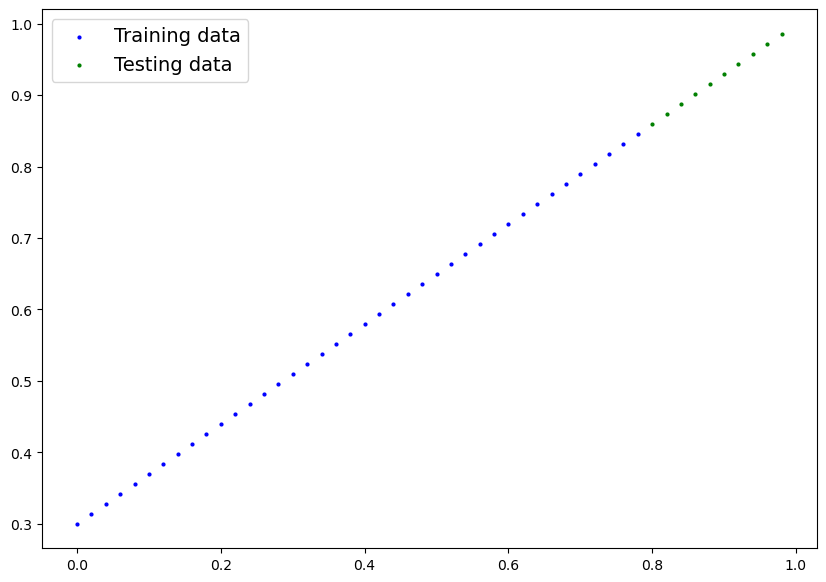

In [60]:
def plot_predictions(train_data=X_train,
                    train_labels=y_train,
                    test_data=X_test,
                    test_labels=y_test,
                    predictions=None):
    """
    Plots training data, test data, and compares predictions
    """
    plt.figure(figsize=(10, 7))

    #Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    #Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    # Are there predictions?
    if predictions != None:
        # Plot predictions
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})

plot_predictions()

## 2. Build Model
What our model does:
* Start with random values for parameters (weight and bias)
* Runs gradient descent to optimize parameters

In [695]:
# Create linear regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch inherits from nn.Module
    def __init__(self):
        super().__init__()
        # initialize model parameters (could be layers, single parameters, or hardcoded values/functions
        # requires_ grad = True; means that PyTorch will track the gradients of this specific parameter for use with torch.autograd and gradient descent
        self.weights = nn.Parameter(torch.randn(1, requires_grad = True, dtype=torch.float32))
        self.bias = nn.Parameter(torch.randn(1, requires_grad = True, dtype=torch.float32))

    # defines the computation in the model
    # any subclass of nn.Module needs to override forward()
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" must be a torch.Tensor and forward must return a torch.Tensor
        return self.weights * x + self.bias # linear regression formula

### PyTorch model building essentials 
* torch.nn - contains all of the building blocks for computational graphs (a neural network can be considered a computational graph)
* torch.nn.Parameter - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
* torch.nn.Module - base class for all neural network modules, if you subclass it you should override forward()
* torch.optim - this is where the optimizers in PyTorch live, they will help with gradient descent
* def forward() - All nn.Module sublclasses require you to overrwrite forward. This method defines what happens in forward computation

 ### Checking contents of our PyTorch model
 check model using - .parameters()

In [748]:
# Create random seed
torch.manual_seed(42)

# Create an instance of the model
model_0 = LinearRegressionModel()

# Check parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [732]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using `torch.inference_mode()`
* when we pass data through our model, it will run it through the forward() method

In [734]:
with torch.inference_mode():
    y_preds = model_0(X_test)
    
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

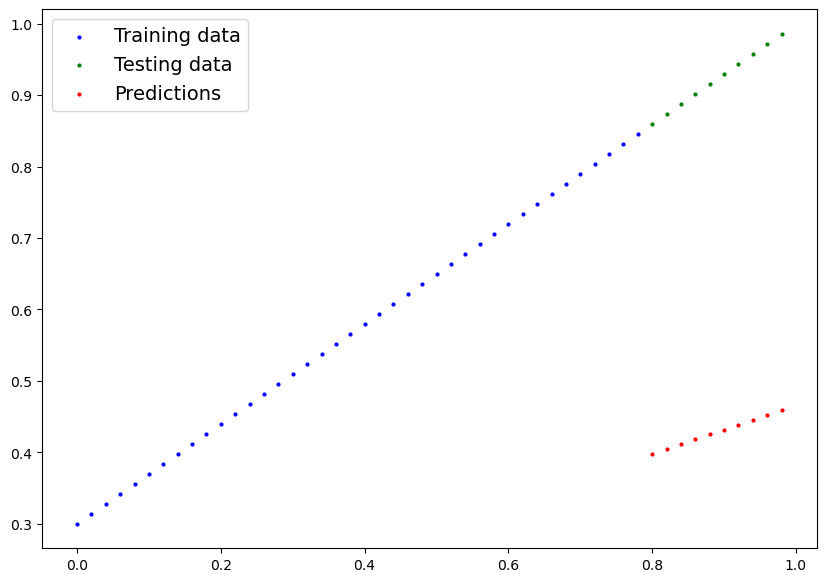

In [736]:
plot_predictions(predictions=y_preds)

## 3. Train the model
Change our parameters to better fit the data

Things we need to train:
* **Loss Function:** A function to measure how off your model's predictions are compared to the correct labels - lower loss function values are better
* **Optimizer:** Takes into account the loss value of a model and adjusts the models parameters to decrease the value of the loss function even further

And specifically for PyTorch, we need:
* A training loop
* A testing loop

In [750]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.001) #lr = learning rate

### Building a training and testing loop in PyTorch 

Things we need in a training loop:
0. Loop through the data and do... {
1. Forward pass (this involves data moving through our model's `forward()` functions) to make predictions on data - aka "forward propogation"
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation**)
5. Optimizer step - use the optimizer to adjust the model's parameters to try and reduce the value of loss (improve the loss)
}

In [740]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [752]:
# an epoch is one loop through the data
epochs = 10000

# Track different values
epoch_count = []
loss_values = []
test_loss_values = []

# 0.
for epoch in range(epochs):
    # Set the model to training mode - sets all parameters that require gradients to require gradients
    model_0.train()
    
    # 1. Forward pass
    y_pred = model_0(X_train)
    
    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Perform backprop on the loss with respect to parameters of the model
    loss.backward()

    # 5. Step the optimizer (perform gradient descent)
    optimizer.step()

    ### Testing
    model_0.eval() # turns off different settings in the model not needed for evaluation/testing
    with torch.inference_mode():
        # 1.
        test_pred = model_0(X_test)

        # 2.
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 1000 == 0:
        # track values
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        
        # print out whats happening
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}") 
        print(model_0.state_dict())
        print("\n")

Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.4931890368461609
OrderedDict([('weights', tensor([0.3371])), ('bias', tensor([0.1298]))])


Epoch: 1000 | Loss: 0.02435957081615925 | Test loss: 0.05690721794962883
OrderedDict([('weights', tensor([0.5790])), ('bias', tensor([0.3508]))])


Epoch: 2000 | Loss: 0.0004444979131221771 | Test loss: 0.0005780101055279374
OrderedDict([('weights', tensor([0.6997])), ('bias', tensor([0.3008]))])


Epoch: 3000 | Loss: 0.0004444979131221771 | Test loss: 0.0005780101055279374
OrderedDict([('weights', tensor([0.6997])), ('bias', tensor([0.3008]))])


Epoch: 4000 | Loss: 0.0004444979131221771 | Test loss: 0.0005780101055279374
OrderedDict([('weights', tensor([0.6997])), ('bias', tensor([0.3008]))])


Epoch: 5000 | Loss: 0.0004444979131221771 | Test loss: 0.0005780101055279374
OrderedDict([('weights', tensor([0.6997])), ('bias', tensor([0.3008]))])


Epoch: 6000 | Loss: 0.0004444979131221771 | Test loss: 0.0005780101055279374
OrderedDict([('weights'

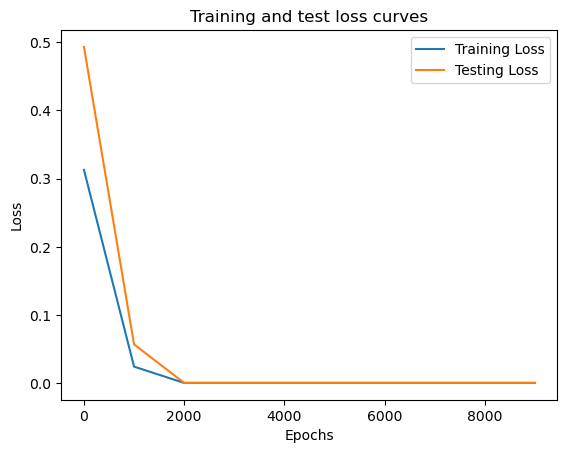

In [766]:
import numpy as np

plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Training Loss")
plt.plot(epoch_count, np.array(torch.tensor(test_loss_values).numpy()), label="Testing Loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

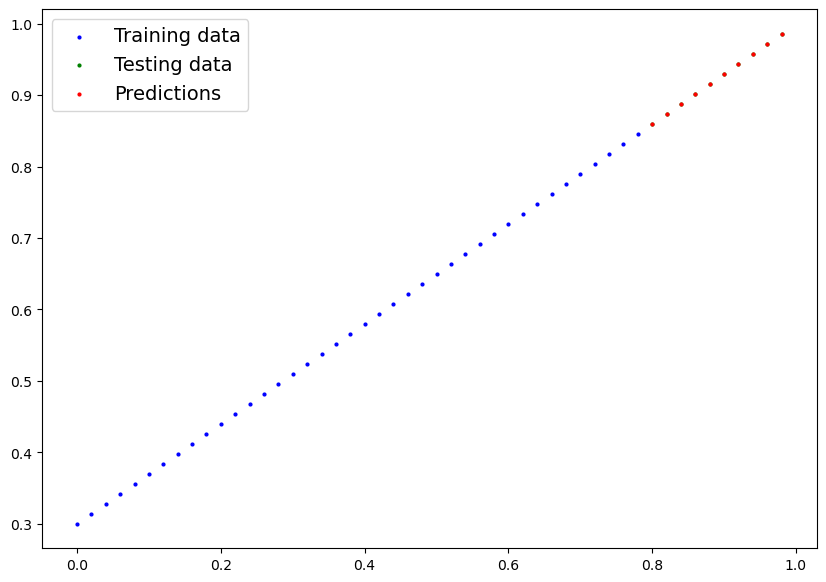

In [754]:
plot_predictions(predictions=test_pred)

## Saving a model in PyTorch

There are three main methods to saving and loading models in PyTorch
1. `torch.save()` - allows you to save a PyTorch object in Python's pickle format
2. `torch.load()` - allows you to load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - this allows you to load a models saved state dictionary

In [771]:
# Saving PyTorch Model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pt"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pt


## Loading a PyTorch Model
Since we saved the models `state_dict()` rather than the entire model, we'll create a new instance of our model class and load the saved `state_dict()` into that.

In [779]:
# Loading a saved state_dict()
load_model = LinearRegressionModel()
load_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
load_model.eval()

LinearRegressionModel()

In [781]:
load_model.state_dict()

OrderedDict([('weights', tensor([0.6994])), ('bias', tensor([0.2998]))])

# Putting it all together

In [54]:
import torch
from torch import nn
import matplotlib.pyplot as plt

In [56]:
weight = 0.7
bias = 0.3

X = torch.arange(0, 1, 0.02).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [58]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_test), len(y_test), len(X_train), len(y_train)

(10, 10, 40, 40)

In [62]:
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters
        self.linear_layer = nn.Linear(in_features=1, # inputting 1 feature to output 1 feature
                                     out_features=1)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

torch.manual_seed(42)
model_2 = LinearRegressionModelV2()
model_2, model_2.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [80]:
# Check the model current device
next(model_2.parameters()).device

device(type='mps', index=0)

In [84]:
# Set the model to use the target device
model_2.to("mps")
next(model_2.parameters()).device

device(type='mps', index=0)

In [88]:
# Setup loss function
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.01)

In [96]:
# Training Loop
torch.manual_seed(42)

epochs = 200

# Put data on the target device (device agnostic code for data)
X_train = X_train.to("mps")
y_train = y_train.to("mps")
X_test = X_test.to("mps")
y_test = y_test.to("mps")

for epoch in range(epochs):
    model_2.train()
    y_train_preds = model_2(X_train)
    train_loss = loss_fn(y_train_preds, y_train)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()


    if epoch % 10 == 0:
        model_2.eval()
        with torch.inference_mode():
            y_test_pred = model_2(X_test)
            test_loss = loss_fn(y_test_pred, y_test)

        print(f"Epoch: {epoch} | Train Loss: {train_loss} | Test Loss: {test_loss}")

Epoch: 0 | Train Loss: 0.5436569452285767 | Test Loss: 0.560505211353302
Epoch: 10 | Train Loss: 0.42844706773757935 | Test Loss: 0.42579540610313416
Epoch: 20 | Train Loss: 0.31323719024658203 | Test Loss: 0.2910855710506439
Epoch: 30 | Train Loss: 0.1980273276567459 | Test Loss: 0.15637575089931488
Epoch: 40 | Train Loss: 0.0828174576163292 | Test Loss: 0.021665919572114944
Epoch: 50 | Train Loss: 0.023356426507234573 | Test Loss: 0.048834484070539474
Epoch: 60 | Train Loss: 0.019609851762652397 | Test Loss: 0.04538799077272415
Epoch: 70 | Train Loss: 0.01618141308426857 | Test Loss: 0.03711546212434769
Epoch: 80 | Train Loss: 0.012742981314659119 | Test Loss: 0.028842901811003685
Epoch: 90 | Train Loss: 0.009307924658060074 | Test Loss: 0.02125726453959942
Epoch: 100 | Train Loss: 0.0058781662955880165 | Test Loss: 0.012984687462449074
Epoch: 110 | Train Loss: 0.002439358038827777 | Test Loss: 0.004712158348411322
Epoch: 120 | Train Loss: 0.010256483219563961 | Test Loss: 0.00033082

In [98]:
model_2.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6929]], device='mps:0')),
             ('linear_layer.bias', tensor([0.2925], device='mps:0'))])

In [120]:
model_2.eval()

with torch.inference_mode():
    y_preds = model_2(X_test)
y_preds, y_test

(tensor([[0.8468],
         [0.8607],
         [0.8746],
         [0.8884],
         [0.9023],
         [0.9161],
         [0.9300],
         [0.9438],
         [0.9577],
         [0.9716]], device='mps:0'),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]], device='mps:0'))

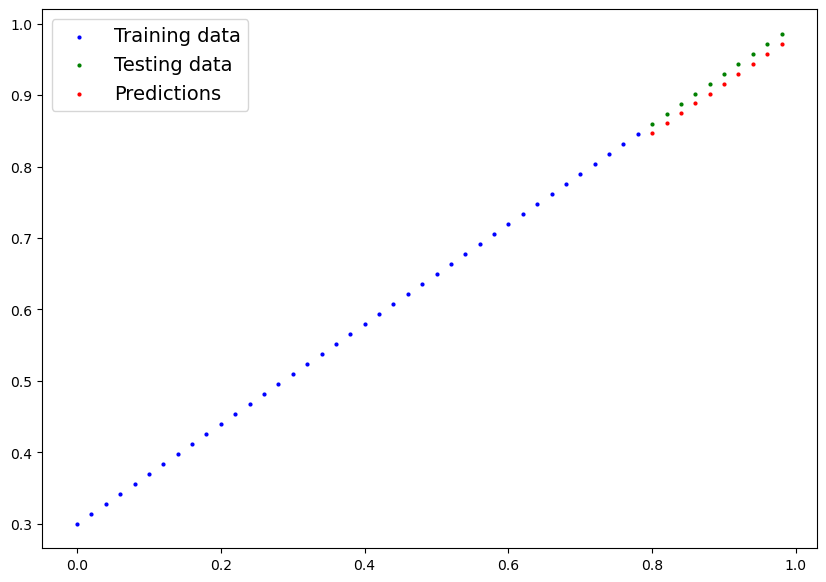

In [122]:
# Plot predictions (move tensor to cpu to make it work with matplotlib)
plot_predictions(predictions=y_preds.cpu())